# Estimating growth rate in the households model

In this notebook, we start by running the UK SEPIR households example and estimating the growth rate directly. We then look at ways we can estimate it without directly solving the equations.

In [1]:
from copy import deepcopy
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap
from numpy import arange, argmin, array, diag,  log, ones, where, zeros
from numpy.linalg import eig
from os.path import isfile
from pandas import read_csv
from pickle import load, dump
from scipy.integrate import solve_ivp
from scipy.sparse import eye, identity
from scipy.sparse import csc_matrix as sparse
from scipy.sparse.linalg import inv
from time import time as get_time
from model.preprocessing import (
        SEPIRInput, HouseholdPopulation, make_initial_condition)
from model.specs import TWO_AGE_SEPIR_SPEC, TWO_AGE_UK_SPEC
from model.common import SEPIRRateEquations
from model.imports import NoImportModel

In [2]:
from os import chdir, getcwd
current_dir = getcwd()
if current_dir[-9:] == 'tutorials':
    chdir('..')

The following block implements and solves the SEPIR model based on UK population parameters:

In [3]:
SPEC = {**TWO_AGE_SEPIR_SPEC, **TWO_AGE_UK_SPEC}

# List of observed household compositions
composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_composition_dist.csv',
    header=0).to_numpy().squeeze()

model_input = SEPIRInput(SPEC, composition_list, comp_dist)

household_population = HouseholdPopulation(
        composition_list, comp_dist, model_input)

rhs = SEPIRRateEquations(model_input, household_population, NoImportModel(5,2))

H0 = make_initial_condition(household_population, rhs)

tspan = (0.0, 365)
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::5])
E = H.T.dot(household_population.states[:, 1::5])
P = H.T.dot(household_population.states[:, 2::5])
I = H.T.dot(household_population.states[:, 3::5])
R = H.T.dot(household_population.states[:, 4::5])
time_series = {
'time':time,
'S':S,
'E':E,
'P':P,
'I':I,
'R':R
}


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.20it/s]


In the next block, we plot the log of the mean "active" infections ($E+P+I$) over time, and the log of the total proportion of households containing an infection $H(\underline{X}:(E+P+I)(\underline{X})>0)$. Comparing the linear segment of these plots, we can see that during the exponential growth phase of the epidemic, the household growth rate is the same as the individual-level growth rate, exactly as predicted by theory.

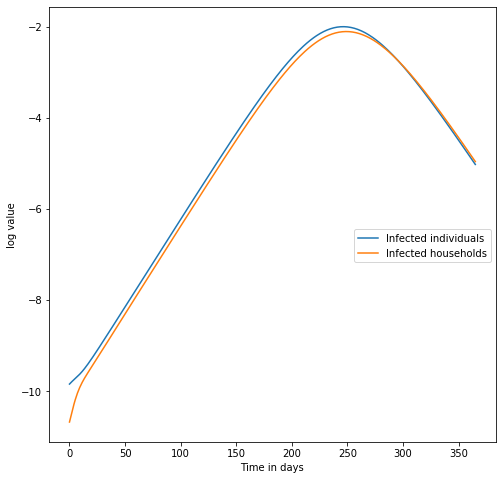

In [4]:
data_list = [time_series['S']/model_input.ave_hh_by_class,
    time_series['E']/model_input.ave_hh_by_class,
    time_series['P']/model_input.ave_hh_by_class,
    time_series['I']/model_input.ave_hh_by_class,
    time_series['R']/model_input.ave_hh_by_class]

log_infs = log((data_list[1]+data_list[2]+data_list[3]).sum(axis=1))
inf_states = where((rhs.states_exp_only + rhs.states_pro_only + rhs.states_inf_only).sum(axis=1)>0)[0]

fig, ax = subplots(1, figsize=(8,8))

ax.plot(time, log_infs,label='Infected individuals')
ax.plot(time, log((H[inf_states]).sum(axis=0)),label='Infected households')
ax.set_xlabel('Time in days')
ax.set_ylabel('log value')
ax.legend(ncol=1, bbox_to_anchor=(1,0.50))

By inspection of the plots, we can see that around day 50 the epidemic is definitely in its exponential growth phase. In the next box we work out which increment of the solver is closest to day 50, then directly calculate the gradient of the log growth curve at this time step, giving us an estimate of the exponential growth rate.

In [5]:
t_50 = argmin(abs(time - 50))
print('Closest time to 50 days is at increment',t_50,', t[',t_50,']=',time[t_50],'.')
r_guess = (log_infs[t_50+1]-log_infs[t_50])/(time[t_50+1]-time[t_50])
print('Direct estimate of log gradient at increment',t_50,'from population estimates is',r_guess,'.')
r_guess_hh = (log((H[inf_states,t_50+1]).sum(axis=0))-log((H[inf_states,t_50]).sum(axis=0)))/(time[t_50+1]-time[t_50])
print('Direct estimate of log gradient at increment',t_50,'from hh estimates is',r_guess_hh,'.')

Closest time to 50 days is at increment 49 , t[ 49 ]= 49.74861010465704 .
Direct estimate of log gradient at increment 49 from population estimates is 0.0383904111955741 .
Direct estimate of log gradient at increment 49 from hh estimates is 0.0386602586100241 .


## Growth rate calculations

We will use an Euler-Lotka approach to do growth rate calculations. Suppose we are in the exponential growth phase of our dynamics. Let $\underline{I}$ be the profile of households typed by composition and risk class of index case, i.e. if infectious households of type $i$ have composition $\underline{N}(i)$ and an index case in risk class $C(i)$, then $I_i$ is the proportion of infected households in this growth phase which are in composition $\underline{N}(i)$ and had their local outbreak seeded by a case in risk class $C(i)$. In the exponential growth phase, this grows according to
$$
\frac{\mathrm{d}\underline{I}}{\mathrm{d}t} = e^{rt}\underline{I}_*,
$$
where $\underline{I}_*$ is the profile of infectious households by composition and index case class at time $t=0$. If $\underline{\underline{\lambda}}(a)$ is the matrix with $(i,j)$th entry giving the rate at which a household of composition-seed type $i$ generates those of composition-seed type $j$ at time $a$ since its original import, then we get the following Euler-Lotka equation
$$
\underline{I}_* = \int\limits_0^{\infty}\underline{I}_* e^{-r\underline{\underline{In}}t}\underline{\underline{\lambda}}\mathrm{d}t.
$$
Assuming we do not see repeat introductions of infection into a single household, we can decompose $\underline{\underline{\lambda}}$ as follows:
$$
\underline{\underline{\lambda}} = \underline{\underline{\alpha}}e^{\underline{\underline{Q}}_{\mathrm{int}}t}\underline{\underline{F}}\underline{\underline{P}}.
$$
Here $\underline{\underline{\alpha}}$ is the matrix mapping composition and import class of household to an initial condition in the households model, $\underline{\underline{F}}$ is infection rate to each class from each composition, and $\underline{\underline{P}}$ is probability that the infection kicked out to a given class ends up in a given type of household. The term $e^{\underline{\underline{Q}}_{\mathrm{int}}t}$ gives the evolution of the within-household system, derived from the fact that we are assuming that after an import there is no other interaction with external households, so the evolution is linear. The Euler-Lotka equation is then
$$
\underline{I}_* = \int\limits_0^{\infty}\underline{I}_* \underline{\underline{\alpha}} e^{(underline{\underline{Q}}_{\mathrm{int}}-r\underline{\underline{In}})t}\underline{\underline{F}}\underline{\underline{P}}\mathrm{d}t,
$$
and integrating we get
$$
\underline{I}_* = \underline{I}_* \underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}.
$$
This is an eigenvector formula with eigenvalue 1, so to find the growth rate, we need to find $r$ such that the transpose of
$$
\underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})\underline{\underline{F}}\underline{\underline{P}}
$$
has leading(?) eigenvalue 1 (cf Pellis, Ferguson and Fraser on households-workplaces models). Because $\underline{\underline{F}}$ scales linearly with the baseline between-household transmission, so estimate between-household transmission we just need to put in a guess, calculate the leading eigenvalue of the compound matrix, then scale the guess by the reciprocal of this eigenvalue to give us a between-household transmission rate which gives us the oberved growth rate. Alternatively, to calculate $r$ based on some parameters, we can just do something like interval bisection in 1D.

In the boxes below, we calculate all the components of this matrix for our UK SEPIR model example.

The following block creates a matrix `reverse_comp_dist` containing the probability that an individual in a given age class is in a household of a given composition - this is a component of our $\underline{\underline{P}}$ matrix.

In [6]:
no_risk_classes = composition_list.shape[1]

reverse_comp_dist = diag(comp_dist).dot(composition_list)
reverse_comp_dist = reverse_comp_dist.dot(diag(1/reverse_comp_dist.sum(0)))

In the following block, `Q_int` is internal evolution matrix, `FOI_by_state` gives expected infection kicked out by a household in a given state (the $\underline{\underline{F}}$ matrix).

In [7]:
Q_int = rhs.Q_int

FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))

for ic in range(rhs.no_inf_compartments):
            states_inf_only =  rhs.inf_by_state_list[ic]
            FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                    rhs.epsilon * states_inf_only.T)).T

In [8]:
index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

no_index_states = len(index_states)
comp_by_index_state = household_population.which_composition[index_states]

The next box creates $\underline{\underline{\alpha}}$

In [9]:
starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))

Next matrix is "probability that an index case in class c results in outbreak in index state i", i.e. $\underline{\underline{P}}$:

In [10]:
index_prob = zeros((no_risk_classes,no_index_states))
for i in range(no_index_states):
    index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
    index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]

The next box combines all this together to give us
$$
\underline{\underline{\alpha}} (r\underline{\underline{In}}-underline{\underline{Q}}_{\mathrm{int}})^{-1}\underline{\underline{F}}\underline{\underline{P}}.
$$

In [11]:
def get_multiplier(r, Q_int, FOI_by_state, index_prob, starter_mat):
    inv_diff = inv(r * identity(Q_int.shape[0]) - Q_int)
    step_1 = FOI_by_state.dot(index_prob)
    step_2 = inv_diff.dot(step_1)
    step_3 = starter_mat.dot(step_2)
    step_4 = step_3
    return step_4

In the boxes below, we empirically calculate the growth rate at each time increment and plot its value over time.

In [12]:
no_tsteps = len(time)
r_range = zeros(no_tsteps-1,)
for tstep in range(no_tsteps-1):
    r_range[tstep] = (log_infs[tstep+1]-log_infs[tstep])/(time[tstep+1]-time[tstep])

Text(0, 0.5, 'Empirical growth rate')

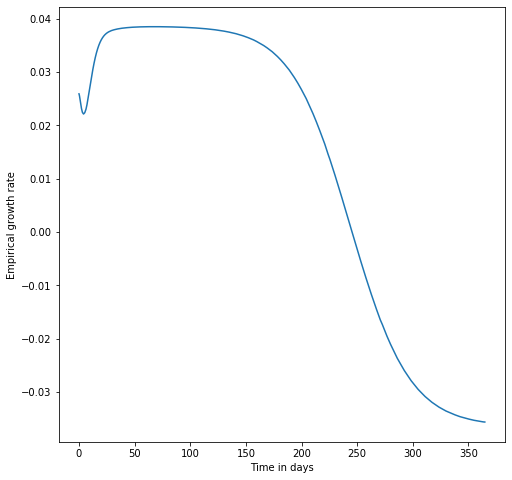

In [13]:
fig, ax = subplots(1, figsize=(8,8))

ax.plot(time[:-1], r_range)
ax.set_xlabel('Time in days')
ax.set_ylabel('Empirical growth rate')

Now estimate the eigenvalue of the multiplier over time based on the growth rates calculated above - note that we need to take its transpose since we did the Euler-Lotka stuff with respect to column vectors.

In [14]:
short_len = int(no_tsteps/10)
multiplier_list = []
evals = zeros(short_len,)

start_time = get_time()

for i in range(short_len):
    multiplier_now = get_multiplier(r_range[10*i], Q_int, FOI_by_state, index_prob, starter_mat)
    multiplier_list.append(multiplier_now)
    evals[i] = eig(multiplier_now.T)[0][0]
    
    time_now = get_time()
    print(i,
          'of',
          short_len,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (short_len-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


0 of 25 calculations completed 9.094403982162476 seconds elapsed,estimated 218.2656955718994 seconds remaining.
1 of 25 calculations completed 18.30631971359253 seconds elapsed,estimated 210.5226767063141 seconds remaining.
2 of 25 calculations completed 27.490914583206177 seconds elapsed,estimated 201.6000402768453 seconds remaining.
3 of 25 calculations completed 36.56436848640442 seconds elapsed,estimated 191.9629345536232 seconds remaining.
4 of 25 calculations completed 45.682201623916626 seconds elapsed,estimated 182.7288064956665 seconds remaining.
5 of 25 calculations completed 54.77260160446167 seconds elapsed,estimated 173.44657174746195 seconds remaining.
6 of 25 calculations completed 63.91105341911316 seconds elapsed,estimated 164.34270879200525 seconds remaining.
7 of 25 calculations completed 73.02186036109924 seconds elapsed,estimated 155.1714532673359 seconds remaining.
8 of 25 calculations completed 82.084805727005 seconds elapsed,estimated 145.92854351467557 seconds 

We now plot the leading eigenvalue of the multiplier.

Text(0, 0.5, 'Leading eigenvalue of multiplier')

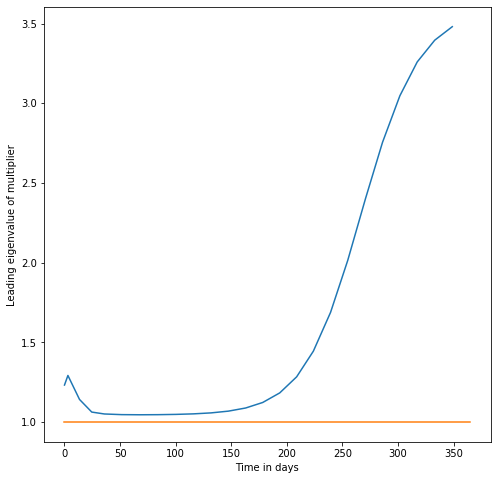

In [15]:
fig, ax = subplots(1, figsize=(8,8))

ax.plot(time[10*arange(short_len)], evals)
ax.plot([time[0],time[-1]],[1,1])
ax.set_xlabel('Time in days')
ax.set_ylabel('Leading eigenvalue of multiplier')

This isn't quite equal to 1 in the exponential growth phase. Unclear currently whether this is a numerical error or an actual mistake.

## More experiments

In the following box we define a function which calculates the time series of eigenvalues for a given set of specs:

In [16]:
composition_list = array([[0,1],[0,2],[1,1],[1,2],[2,1],[2,2]])
comp_dist = (1/len(composition_list)) * ones(len(composition_list),)
no_risk_classes = composition_list.shape[1]
reverse_comp_dist = diag(comp_dist).dot(composition_list)
reverse_comp_dist = reverse_comp_dist.dot(diag(1/reverse_comp_dist.sum(0)))

def get_r_time_series_and_evals(spec):

    model_input = SEPIRInput(spec, composition_list, comp_dist)

    household_population = HouseholdPopulation(
            composition_list, comp_dist, model_input)

    rhs = SEPIRRateEquations(model_input, household_population, NoImportModel(5,2))

    H0 = make_initial_condition(household_population, rhs)

    tspan = (0.0, 150)
    solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)

    time = solution.t
    H = solution.y
    S = H.T.dot(household_population.states[:, ::5])
    E = H.T.dot(household_population.states[:, 1::5])
    P = H.T.dot(household_population.states[:, 2::5])
    I = H.T.dot(household_population.states[:, 3::5])
    R = H.T.dot(household_population.states[:, 4::5])

    log_infs = log((E + P + I).sum(axis=1))
    no_tsteps = len(time)
    r_range = zeros(no_tsteps-1,)
    for tstep in range(no_tsteps-1):
        r_range[tstep] = (log_infs[tstep+1]-log_infs[tstep])/(time[tstep+1]-time[tstep])
        
    Q_int = rhs.Q_int

    FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))

    for ic in range(rhs.no_inf_compartments):
                states_inf_only =  rhs.inf_by_state_list[ic]
                FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                        rhs.epsilon * states_inf_only.T)).T
    
    index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

    no_index_states = len(index_states)
    comp_by_index_state = household_population.which_composition[index_states]
    
    starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))
    
    index_prob = zeros((no_risk_classes,no_index_states))
    for i in range(no_index_states):
        index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
        index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]
        
    short_len = int(no_tsteps/10)
    multiplier_list = []
    evals = zeros(short_len,)
    for j in range(short_len):
        multiplier_now = get_multiplier(r_range[10*j], Q_int, FOI_by_state, index_prob, starter_mat)
        multiplier_list.append(multiplier_now)
        eval_list = eig(multiplier_now.T)[0]
#         evals[j] = eval_list[argmin(abs(eval_list - ones(eval_list.shape)))]
        evals[j] = eval_list[0]
    
    return r_range, time, evals


We now calculate the eigenvalue time series for this simple small-households model over a range of household-level reproductive ratio ($R_*$) values:

In [17]:
r_range_list = []
time_list = []
eval_range_list = []

RG_range = arange(1.1,2,0.1)

no_steps = len(RG_range)
start_time = get_time()
for i in range(no_steps):
    RG_now = RG_range[i]
    spec = deepcopy(SPEC)
    spec['R*'] = RG_now
    r_now, t_now, evals_now = get_r_time_series_and_evals(spec)
    r_range_list.append(r_now)
    time_list.append(t_now)
    eval_range_list.append(evals_now)
    time_now = get_time()
    print(i,
          'of',
          no_steps,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (no_steps-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.26it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


0 of 9 calculations completed 1.9418861865997314 seconds elapsed,estimated 15.535089492797852 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


1 of 9 calculations completed 3.8865981101989746 seconds elapsed,estimated 13.603093385696411 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77.96it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


2 of 9 calculations completed 5.892183065414429 seconds elapsed,estimated 11.784366130828857 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.04it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


3 of 9 calculations completed 7.9529783725738525 seconds elapsed,estimated 9.941222965717316 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 64.51it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


4 of 9 calculations completed 10.172860622406006 seconds elapsed,estimated 8.138288497924805 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 71.47it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


5 of 9 calculations completed 12.186736583709717 seconds elapsed,estimated 6.093368291854858 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.97it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


6 of 9 calculations completed 14.208015441894531 seconds elapsed,estimated 4.0594329833984375 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


7 of 9 calculations completed 16.219671964645386 seconds elapsed,estimated 2.027458995580673 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.62it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


8 of 9 calculations completed 18.23232102394104 seconds elapsed,estimated 0.0 seconds remaining.


Now plot the time series:

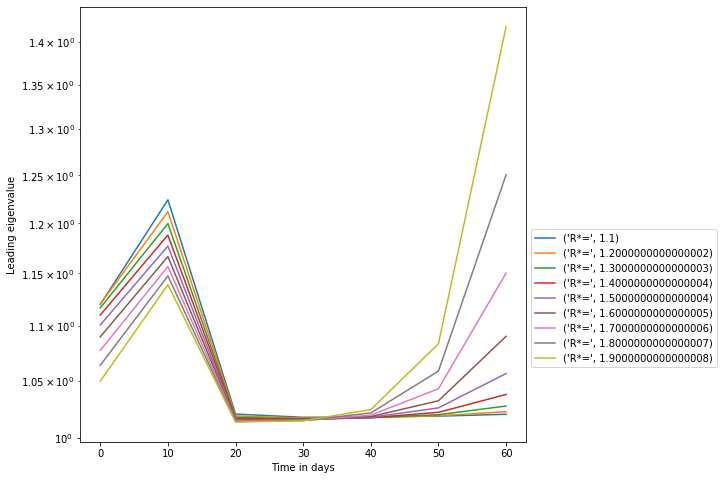

In [18]:
from matplotlib.pyplot import yscale

fig, ax = subplots(1, figsize=(8,8))

for i in range(no_steps):
    ax.plot(10*arange(len(eval_range_list[i])), eval_range_list[i], label=('R*=',RG_range[i]))
yscale('log')
ax.set_ylabel('Leading eigenvalue')
ax.set_xlabel('Time in days')
ax.legend(ncol=1, bbox_to_anchor=(1,0.50))

For all of the reproductive ratios, the eigenvalue settles around 1 during the exponential growth phase.

To do some more robust testing, we now define a function that generates a random set of parameters.

In [19]:
from numpy.random import rand

def draw_random_specs(spec):
    
    rand_spec = deepcopy(spec)
    rand_spec['AR'] = 0.25 + 0.5*rand(1,) # SAR between 0.25 and 0.75
    rand_spec['R*'] = 1 + rand(1,) # R* between 1 and 2
    rand_spec['recovery_rate'] = 1/(1 + 7 * rand(1,)) # Fix inf period between 1 and 7 days
    rand_spec['incubation_rate'] = 1/(1 + 9 * rand(1)) # Fix inc period between 1 and 10 days
    rand_spec['symp_onset_rate'] = 1/(1 + 5 * rand(1)) # Fix prodromal period between 1 and 5 days
    rand_spec['prodromal_trans_scaling'] = rand(no_risk_classes,) # Random prodrome scalings <1
    unscaled_sus = rand(no_risk_classes,)
    rand_spec['sus'] = unscaled_sus/unscaled_sus.max() # Set sus of most sus class to 1, all others <1
    rand_spec['density_expo'] = rand(1,)
    
    return rand_spec

Now carry out the eigenvalue calculations for 50 of these parameter sets, and plot the resulting eigenvalue time series.

In [20]:
no_samples = 50

r_range_list = []
time_list = []
eval_range_list = []

start_time = get_time()
for i in range(no_samples):
    spec = draw_random_specs(SPEC)
    r_now, t_now, evals_now = get_r_time_series_and_evals(spec)
    r_range_list.append(r_now)
    time_list.append(t_now)
    eval_range_list.append(evals_now)
    time_now = get_time()
    print(i,
          'of',
          no_samples,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (no_samples-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.61it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


0 of 50 calculations completed 2.2815756797790527 seconds elapsed,estimated 111.79720830917358 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.62it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


1 of 50 calculations completed 4.665324687957764 seconds elapsed,estimated 111.96779251098633 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 71.69it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


2 of 50 calculations completed 6.468415260314941 seconds elapsed,estimated 101.33850574493408 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 70.69it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


3 of 50 calculations completed 10.205259561538696 seconds elapsed,estimated 117.36048495769501 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.50it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


4 of 50 calculations completed 12.821163415908813 seconds elapsed,estimated 115.39047074317932 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.10it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


5 of 50 calculations completed 15.916270732879639 seconds elapsed,estimated 116.71931870778401 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.05it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


6 of 50 calculations completed 17.309712648391724 seconds elapsed,estimated 106.33109198297772 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.66it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


7 of 50 calculations completed 18.939255952835083 seconds elapsed,estimated 99.43109375238419 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 67.39it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


8 of 50 calculations completed 21.51947855949402 seconds elapsed,estimated 98.03318010436163 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 78.22it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


9 of 50 calculations completed 23.714768648147583 seconds elapsed,estimated 94.85907459259033 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 76.33it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


10 of 50 calculations completed 25.938888549804688 seconds elapsed,estimated 91.96515031294389 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 74.93it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


11 of 50 calculations completed 29.318613529205322 seconds elapsed,estimated 92.84227617581685 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.81it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


12 of 50 calculations completed 33.2802152633667 seconds elapsed,estimated 94.72061267265907 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 79.13it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


13 of 50 calculations completed 36.3914840221405 seconds elapsed,estimated 93.57810177121844 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 90.00it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


14 of 50 calculations completed 37.885613679885864 seconds elapsed,estimated 88.39976525306702 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 92.94it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


15 of 50 calculations completed 39.29078221321106 seconds elapsed,estimated 83.4929122030735 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 93.16it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


16 of 50 calculations completed 41.0644588470459 seconds elapsed,estimated 79.71336129132439 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.50it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


17 of 50 calculations completed 42.615453004837036 seconds elapsed,estimated 75.76080534193251 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.10it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


18 of 50 calculations completed 44.6855309009552 seconds elapsed,estimated 72.90797146997954 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 86.64it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


19 of 50 calculations completed 46.73095774650574 seconds elapsed,estimated 70.0964366197586 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 79.34it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


20 of 50 calculations completed 49.900009870529175 seconds elapsed,estimated 68.90953744025458 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.93it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


21 of 50 calculations completed 53.197787284851074 seconds elapsed,estimated 67.7062747261741 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.39it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


22 of 50 calculations completed 55.56743764877319 seconds elapsed,estimated 65.23133984855984 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.38it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


23 of 50 calculations completed 58.316490173339844 seconds elapsed,estimated 63.17619768778483 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 87.76it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


24 of 50 calculations completed 60.29223275184631 seconds elapsed,estimated 60.29223275184631 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 78.42it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


25 of 50 calculations completed 63.827656984329224 seconds elapsed,estimated 58.9178372163039 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.15it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


26 of 50 calculations completed 66.90070533752441 seconds elapsed,estimated 56.98948973196524 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 83.38it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


27 of 50 calculations completed 69.50847816467285 seconds elapsed,estimated 54.61380427224295 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.72it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


28 of 50 calculations completed 71.03737473487854 seconds elapsed,estimated 51.44085756663618 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.96it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


29 of 50 calculations completed 73.47743582725525 seconds elapsed,estimated 48.984957218170166 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 88.18it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


30 of 50 calculations completed 75.33918571472168 seconds elapsed,estimated 46.17562995418425 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.76it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


31 of 50 calculations completed 77.43494606018066 seconds elapsed,estimated 43.55715715885162 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.04it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


32 of 50 calculations completed 79.49942684173584 seconds elapsed,estimated 40.954250191197254 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 87.83it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


33 of 50 calculations completed 81.9044280052185 seconds elapsed,estimated 38.543260237749884 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 78.98it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


34 of 50 calculations completed 83.75344729423523 seconds elapsed,estimated 35.89433455467224 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.89it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


35 of 50 calculations completed 86.22555756568909 seconds elapsed,estimated 33.532161275545754 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.99it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


36 of 50 calculations completed 87.93378782272339 seconds elapsed,estimated 30.895655180956865 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.03it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


37 of 50 calculations completed 90.2227463722229 seconds elapsed,estimated 28.491393591228285 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.03it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


38 of 50 calculations completed 91.793527841568 seconds elapsed,estimated 25.890482211724304 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.27it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


39 of 50 calculations completed 94.86171627044678 seconds elapsed,estimated 23.715429067611694 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 88.72it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


40 of 50 calculations completed 96.40028667449951 seconds elapsed,estimated 21.16103853830477 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 93.72it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


41 of 50 calculations completed 99.29659581184387 seconds elapsed,estimated 18.91363729749407 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 73.73it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


42 of 50 calculations completed 101.2297101020813 seconds elapsed,estimated 16.479255132896956 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.04it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


43 of 50 calculations completed 103.90912818908691 seconds elapsed,estimated 14.169426571239125 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 85.20it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


44 of 50 calculations completed 106.14975261688232 seconds elapsed,estimated 11.79441695743137 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 80.05it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


45 of 50 calculations completed 107.91580009460449 seconds elapsed,estimated 9.383982616922129 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 88.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


46 of 50 calculations completed 111.0837972164154 seconds elapsed,estimated 7.090455141473324 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 84.55it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


47 of 50 calculations completed 113.57038307189941 seconds elapsed,estimated 4.732099294662476 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 75.04it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


48 of 50 calculations completed 117.71488332748413 seconds elapsed,estimated 2.4023445577037577 seconds remaining.


Building within-household transmission matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 77.08it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


49 of 50 calculations completed 119.5332293510437 seconds elapsed,estimated 0.0 seconds remaining.


Text(0.5, 0, 'Time in days')

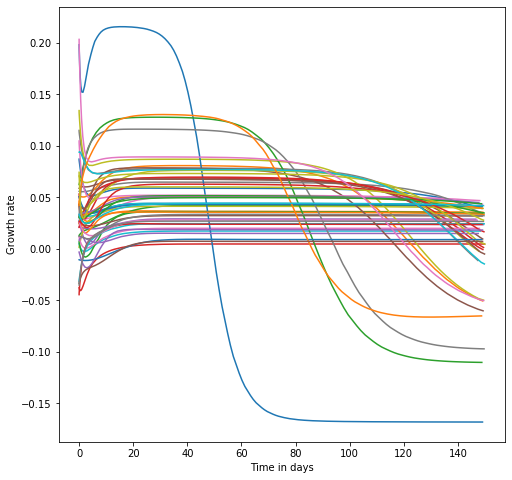

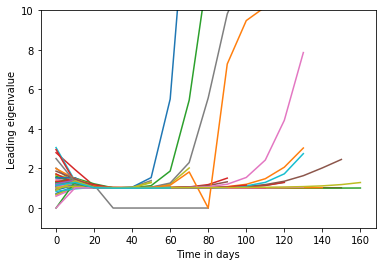

In [21]:
fig, ax = subplots(1, figsize=(8,8))

for i in range(no_samples):
    ax.plot(time_list[i][:-1], r_range_list[i])
ax.set_ylabel('Growth rate')
ax.set_xlabel('Time in days')

fig, ax = subplots(1)

for i in range(no_samples):
    ax.plot(10*arange(len(eval_range_list[i])), eval_range_list[i])
ax.set_ylim([-1,10])
ax.set_ylabel('Leading eigenvalue')
ax.set_xlabel('Time in days')

Because we have not directly checked all of the parameter sets, there may be "bad" parameter sets samples which lead to strange behaviours in the model, although in theory all of them should allow for a sustained outbreak of infection. You should find that in the plot, most of the trajectories appear to settle around one during the period in their dynamics where the growth rate is constant.

## Calculating growth rate from model parameters

The tests above suggest that the eigenvector equation we have identified holds; if we measure the growth rate $r$ during the exponential growth phase, then the leading eigenvalue of the compound matrix comes out as 1.

In [22]:
SPEC = {**TWO_AGE_SEPIR_SPEC, **TWO_AGE_UK_SPEC}

# List of observed household compositions
composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_composition_dist.csv',
    header=0).to_numpy().squeeze()
no_risk_classes = composition_list.shape[1]
reverse_comp_dist = diag(comp_dist).dot(composition_list)
reverse_comp_dist = reverse_comp_dist.dot(diag(1/reverse_comp_dist.sum(0)))

model_input = SEPIRInput(SPEC, composition_list, comp_dist)

household_population = HouseholdPopulation(
        composition_list, comp_dist, model_input)

rhs = SEPIRRateEquations(model_input, household_population, NoImportModel(5,2))

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.80it/s]


In [48]:
def estimate_growth_rate(household_population,rhs,interval=[0.01,0.1],tol=1e-3):
    
    Q_int = rhs.Q_int
    FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))
    for ic in range(rhs.no_inf_compartments):
                states_inf_only =  rhs.inf_by_state_list[ic]
                FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                        rhs.epsilon * states_inf_only.T)).T
    index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

    no_index_states = len(index_states)
    comp_by_index_state = household_population.which_composition[index_states]
    
    starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))
    
    index_prob = zeros((no_risk_classes,no_index_states))
    for i in range(no_index_states):
        index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
        index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]
        
    r_min = interval[0]
    r_max = interval[1]
    multiplier = get_multiplier(r_min, Q_int, FOI_by_state, index_prob, starter_mat)
    eval_min = eig(multiplier.T)[0][0]
    print('eval at min=',eval_min)
    multiplier = get_multiplier(r_max, Q_int, FOI_by_state, index_prob, starter_mat)
    eval_max = eig(multiplier.T)[0][0]
    print('eval at max=',eval_max)
    
    if ((eval_min-1) * (eval_max-1) > 0):
        print('Solution not contained within interval')
        return None

    while (r_max - r_min > tol):
        r_now = 0.5 * (r_max + r_min)
        multiplier = get_multiplier(r_now, Q_int, FOI_by_state, index_prob, starter_mat)
        eval_now = eig(multiplier.T)[0][0]
#         print('eval at r =',r_now,'is',eval_now)
        if ((eval_now-1) * (eval_max-1) > 0):
            r_max = r_now
        else:
            r_min = r_now
    
    return r_now

In [24]:
r_est = estimate_growth_rate(household_population,rhs)

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.5459497483476308+0j)
eval at max= (0.5417507825899424+0j)
eval at r = 0.055 is (0.8579530748862363+0j)
eval at r = 0.0325 is (1.128451793155857+0j)
eval at r = 0.04375 is (0.9795852917096448+0j)
eval at r = 0.038125 is (1.0501437840626455+0j)
eval at r = 0.0409375 is (1.0139607658437342+0j)
eval at r = 0.04234375 is (0.9965546192292232+0j)
eval at r = 0.041640625 is (1.0052021727737501+0j)


In [25]:
H0 = make_initial_condition(household_population, rhs)

tspan = (0.0, 365)
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::5])
E = H.T.dot(household_population.states[:, 1::5])
P = H.T.dot(household_population.states[:, 2::5])
I = H.T.dot(household_population.states[:, 3::5])
R = H.T.dot(household_population.states[:, 4::5])
time_series = {
'time':time,
'S':S,
'E':E,
'P':P,
'I':I,
'R':R
}

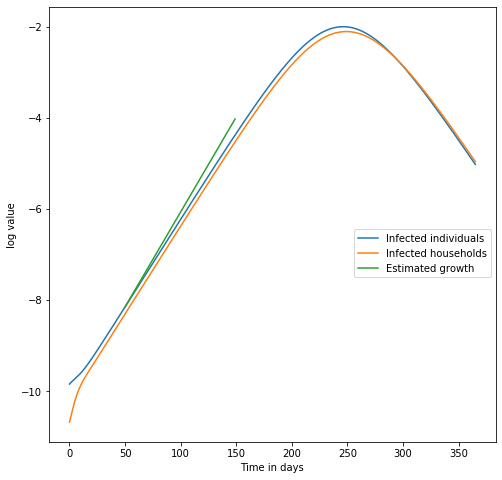

In [26]:
data_list = [time_series['S']/model_input.ave_hh_by_class,
    time_series['E']/model_input.ave_hh_by_class,
    time_series['P']/model_input.ave_hh_by_class,
    time_series['I']/model_input.ave_hh_by_class,
    time_series['R']/model_input.ave_hh_by_class]

log_infs = log((data_list[1]+data_list[2]+data_list[3]).sum(axis=1))
inf_states = where((rhs.states_exp_only + rhs.states_pro_only + rhs.states_inf_only).sum(axis=1)>0)[0]

t_50 = argmin(abs(time - 50))
t_150 = argmin(abs(time - 150))
log_inf_est = log_infs[t_50] + r_est * (time[t_50:t_150] - time[t_50])

fig, ax = subplots(1, figsize=(8,8))

ax.plot(time, log_infs,label='Infected individuals')
ax.plot(time, log((H[inf_states]).sum(axis=0)),label='Infected households')
ax.plot(time[t_50:t_150], log_inf_est, label='Estimated growth')
ax.set_xlabel('Time in days')
ax.set_ylabel('log value')
ax.legend(ncol=1, bbox_to_anchor=(1,0.50))

Our method slightly overestimates the growth rate.

## Estimating between-household mixing from a growth rate

Given a growth rate $r$, we can estimate the compound matrix
$$
\underline{\underline{\alpha}}(\underline{\underline{Q}} - r\underline{\underline{In}})^{-1}\underline{\underline{F}}\underline{\underline{P}}.
$$
Because $\underline{\underline{F}}$, the "force of infection" matrix, is linear in the baseline between-household mixing rate, we can rewrite the matrix as
$$
\beta_G\underline{\underline{\alpha}}(\underline{\underline{Q}} - r\underline{\underline{In}})^{-1}\underline{\underline{\tilde{F}}}\underline{\underline{P}}.
$$
where $\beta_G$ is the between-household mixing rate. Hence, to estimate this rate, we calculate
$$
\underline{\underline{\alpha}}(\underline{\underline{Q}} - r\underline{\underline{In}})^{-1}\underline{\underline{\tilde{F}(1)}}\underline{\underline{P}}.
$$
where $\underline{\underline{\tilde{F}}}(1)$ is the force of infection matrix calculated with $\beta_G$ fixed at 1, calculate its leading eigenvalue $\lambda$, and then set
$$
\beta_G = 1/\lambda.
$$

In the next block we define reformatted specs and input, suitable for fitting. The external matrix, `k_ext`, is scaled to have eigenvalue 1.

In [33]:
from numpy import shape
from model.preprocessing import ModelInput

SEPIR_SPEC_FOR_FITTING = {
    'compartmental_structure': 'SEPIR', # This is which subsystem key to use
    'AR': 0.45,                     # Secondary attack probability
    'recovery_rate': 1/4,           # Recovery rate
    'incubation_rate': 1/5,         # E->P incubation rate
    'symp_onset_rate': 1/3,         # P->I prodromal to symptomatic rate
    'prodromal_trans_scaling':
     array([0.5,0.5]),          # Prodromal transmission intensity relative to full inf transmission
    'sus': array([1,1]),          # Relative susceptibility by age/vulnerability class
    'density_expo' : 0.5, # "Cauchemez parameter"
}

class SEPIRInputForFitting(ModelInput):
    def __init__(self, spec, composition_list, composition_distribution):
        super().__init__(spec, composition_list, composition_distribution)

        self.sus = spec['sus']
        self.inf_scales = [spec['prodromal_trans_scaling'],
                ones(shape(spec['prodromal_trans_scaling']))]

        home_eig = max(eig(
            self.sus * ((1/spec['recovery_rate']) *
             (self.k_home) + \
            (1/spec['symp_onset_rate']) *
            (self.k_home ) * spec['prodromal_trans_scaling'])
            )[0])
        ext_eig = max(eig(
            self.sus * ((1/spec['recovery_rate']) *
             (self.k_ext) + \
            (1/spec['symp_onset_rate']) *
            (self.k_ext ) * spec['prodromal_trans_scaling'])
            )[0])

        R_int = - log(1 - spec['AR']) * self.dens_adj_ave_hh_size

        self.k_home = R_int * self.k_home / home_eig
        external_scale = 1/(self.ave_hh_size*spec['AR'])
        self.k_ext = external_scale * self.k_ext / ext_eig



    @property
    def alpha_1(self):
        return self.spec['incubation_rate']

    @property
    def alpha_2(self):
        return self.spec['symp_onset_rate']

    @property
    def gamma(self):
        return self.spec['recovery_rate']

In [34]:
SPEC = {**SEPIR_SPEC_FOR_FITTING, **TWO_AGE_UK_SPEC}

model_input_to_fit = SEPIRInputForFitting(SPEC, composition_list, comp_dist)

household_population_to_fit = HouseholdPopulation(
        composition_list, comp_dist, model_input_to_fit)

rhs_to_fit = SEPIRRateEquations(model_input_to_fit, household_population_to_fit, NoImportModel(5,2))

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.08it/s]


The following function estimates `beta_ext`, a scaling on `k_ext`, to match an inputted growth rate `r`.

In [35]:
def estimate_beta_ext(household_population,rhs,r):
    
    Q_int = rhs.Q_int
    FOI_by_state = zeros((Q_int.shape[0],no_risk_classes))
    for ic in range(rhs.no_inf_compartments):
                states_inf_only =  rhs.inf_by_state_list[ic]
                FOI_by_state += (rhs.ext_matrix_list[ic].dot(
                        rhs.epsilon * states_inf_only.T)).T
    index_states = where(
    ((rhs.states_exp_only.sum(axis=1)==1) * 
    ((rhs.states_pro_only + rhs.states_inf_only + rhs.states_rec_only).sum(axis=1)==0)))[0]

    no_index_states = len(index_states)
    comp_by_index_state = household_population.which_composition[index_states]
    
    starter_mat = sparse((ones(no_index_states),(range(no_index_states), index_states)),shape=(no_index_states,Q_int.shape[0]))
    
    index_prob = zeros((no_risk_classes,no_index_states))
    for i in range(no_index_states):
        index_class = where(rhs.states_exp_only[index_states[i],:]==1)[0]
        index_prob[index_class,i] = reverse_comp_dist[comp_by_index_state[i], index_class]
        
    multiplier = get_multiplier(r, Q_int, FOI_by_state, index_prob, starter_mat)
    evalue = eig(multiplier.T)[0][0]
    
    beta_ext = 1/evalue
    
    return beta_ext

We now estimate `beta_ext` based on the growth rate we estimated earlier, and then estimate a growth rate from this fitted `beta_ext`.

In [36]:
beta_ext_guess = estimate_beta_ext(household_population_to_fit, rhs_to_fit, r_est)

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [37]:
beta_ext_guess

(1.0943072247492904+0j)

In [41]:
fitted_model_input = deepcopy(model_input_to_fit)
fitted_model_input.k_ext = beta_ext_guess.real * fitted_model_input.k_ext
fitted_household_population = HouseholdPopulation(
        composition_list, comp_dist, fitted_model_input)

fitted_rhs = SEPIRRateEquations(fitted_model_input, fitted_household_population, NoImportModel(5,2))

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.68it/s]


In [42]:
r_est_new = estimate_growth_rate(fitted_household_population,fitted_rhs)

C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.5379490715601454+0j)
eval at max= (0.5389470867288688+0j)
eval at r = 0.055 is (0.8535129530398888+0j)
eval at r = 0.0325 is (1.1226117727561322+0j)
eval at r = 0.04375 is (0.9745156927054596+0j)
eval at r = 0.038125 is (1.0447090272048287+0j)
eval at r = 0.0409375 is (1.0087132651592023+0j)
eval at r = 0.04234375 is (0.9913971997089248+0j)
eval at r = 0.041640625 is (0.9999999999999997+0j)


In [43]:
print('old r estimate is', r_est, ', new r estimate is', r_est_new,'.')

old r estimate is 0.041640625 , new r estimate is 0.041640625 .


We appear to be able to obtain the growth rate we fitted to. We now need to test the opposite method, calculating `beta_ext` based on a growth rate estimated from an inputted value of `beta_ext`.

In [54]:
def fit_beta_from_beta(SPEC, beta_ext):
    fitted_model_input = SEPIRInputForFitting(SPEC, composition_list, comp_dist)
    fitted_model_input.k_ext = beta_ext * fitted_model_input.k_ext
    fitted_household_population = HouseholdPopulation(
        composition_list, comp_dist, fitted_model_input)

    fitted_rhs = SEPIRRateEquations(fitted_model_input, fitted_household_population, NoImportModel(5,2))
    r_est = estimate_growth_rate(fitted_household_population,fitted_rhs,[0.001,5])
    
    model_input_to_fit = SEPIRInputForFitting(SPEC, composition_list, comp_dist)

    household_population_to_fit = HouseholdPopulation(
        composition_list, comp_dist, model_input_to_fit)

    rhs_to_fit = SEPIRRateEquations(model_input_to_fit, household_population_to_fit, NoImportModel(5,2))
    
    beta_ext_guess = estimate_beta_ext(household_population_to_fit, rhs_to_fit, r_est)
    
    return beta_ext_guess

In [45]:
new_beta_ext = fit_beta_from_beta(SPEC, 1.2)
print('Estimated beta_ext is',new_beta_ext)

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.97it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.6864906345610522+0j)
eval at max= (0.591000853734482+0j)
eval at r = 0.055 is (0.9359488089668033+0j)
eval at r = 0.0325 is (1.2310383198063901+0j)
eval at r = 0.04375 is (1.0686385000468859+0j)
eval at r = 0.049375 is (0.9990528591223837+0j)
eval at r = 0.0465625 is (1.0329822942106415+0j)
eval at r = 0.047968750000000004 is (1.015808711156088+0j)
eval at r = 0.048671875 is (1.0073794110376997+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.81it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In the box below we randomly sample values of `beta_ext` and then try to re-obtain them from the estimated growth rate.

In [56]:
beta_in = []
beta_out = []

no_samples = 10

start_time = get_time()
for i in range(no_samples):
    beta_rand =  0.9 + rand(1,)
    beta_fit = fit_beta_from_beta(SPEC, beta_rand)
    beta_in.append(beta_rand)
    beta_out.append(beta_fit)
    time_now = get_time()
    print(i,
          'of',
          no_samples,
          'calculations completed',
          time_now-start_time,
          'seconds elapsed,estimated',
         (no_samples-(i+1))*(time_now-start_time)/(i+1),
         'seconds remaining.')

Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.74it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (2.7420529531882725+0j)
eval at max= (0.0012005878186217174+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.14it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


0 of 10 calculations completed 137.99730348587036 seconds elapsed,estimated 1241.9757313728333 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (2.7486479051594435+0j)
eval at max= (-2.168404344971009e-19+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.12it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


1 of 10 calculations completed 275.1065528392792 seconds elapsed,estimated 1100.4262113571167 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.26it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (2.433347769945067+0j)
eval at max= (-2.168404344971009e-19+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.11it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


2 of 10 calculations completed 413.21512365341187 seconds elapsed,estimated 964.168621857961 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.28it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.953728360117848+0j)
eval at max= (0.0008554256646743258+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.74it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


3 of 10 calculations completed 551.9773461818695 seconds elapsed,estimated 827.9660192728043 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 18.70it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.8136953320898725+0j)
eval at max= (0.0007941132281440161+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.28it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


4 of 10 calculations completed 703.4058656692505 seconds elapsed,estimated 703.4058656692505 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.16it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.7853436908861782+0j)
eval at max= (0.000781699669526371+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.29it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


5 of 10 calculations completed 854.6011536121368 seconds elapsed,estimated 569.7341024080912 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.06it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (1.5509414462252167+0j)
eval at max= (0.0006790683621074826+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.02it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


6 of 10 calculations completed 1006.9074730873108 seconds elapsed,estimated 431.53177418027605 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 19.89it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (2.550509887078783+0j)
eval at max= (0.0011167220888789286+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.15it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


7 of 10 calculations completed 1155.234657049179 seconds elapsed,estimated 288.80866426229477 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 19.85it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (2.517976427430736+0j)
eval at max= (0.0011024775516588683+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 19.89it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


8 of 10 calculations completed 1303.7161102294922 seconds elapsed,estimated 144.8573455810547 seconds remaining.


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 19.62it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


eval at min= (2.5252170794520326+0j)
eval at max= (0.0011056478181577472+0j)


Building within-household transmission matrix: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.27it/s]
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\Users\Joe Hilton\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


9 of 10 calculations completed 1451.2046294212341 seconds elapsed,estimated 0.0 seconds remaining.


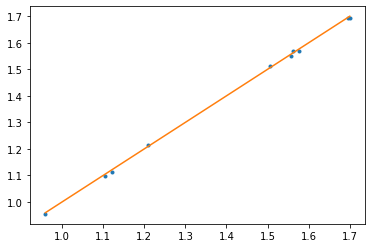

In [58]:
fig, ax = subplots(1)

ax.plot(beta_in, beta_out, '.')
ax.plot([min(beta_in), max(beta_in)],[min(beta_in), max(beta_in)])

In [84]:
from numpy import sqrt

beta_abs_err = abs(array(beta_in).T - array(beta_out).real)
beta_rel_err = abs(array(beta_in).T - array(beta_out).real)/array(beta_in).T
print('Mean relative error is',beta_abs_err.mean())
print('Mean absolute error is',beta_rel_err.mean())
print('RMSE is',sqrt(((array(beta_in).T - array(beta_out).real) ** 2).mean()))

Mean relative error is 0.006830509912151251
Mean absolute error is 0.005017397489541376
RMSE is 0.0069606781243509545
